## 1. Introduction

Predictive insurance cost estimates is an important topic in healthcare industry. For individuals, a better understanding of insurance costs leads to more informed decisions about what coverage options to choose. For insurers, they can price their policies more efficiently by accurately predicting insurance costs.

This project is going to predict the insurance cost with 3 models: Logistic Regression Classifier, Decision Trees Classifier, and Random Forest Classifier.

The dataset can be found in [Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance). It has the following fields:
- `age`: age of primary beneficiary
- `sex`: insurance contractor gender, female, male
- `bmi`: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- `children`: Number of children covered by health insurance / Number of dependents
- `smoker`: Smoking
- `region`: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- `charges`: Individual medical costs billed by health insurance

where `charges` is our target.

## 2. Import the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid

# ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)

# set float format
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# set seaborn theme
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 
                 "figure.dpi":100, 'savefig.dpi':100}
sns.set_theme(style="ticks", rc=custom_params)
%config InlineBackend.figure_format = "retina"

2023-02-06 14:01:23.798704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("data/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.924
1,18,male,33.770,1,no,southeast,1725.552
2,28,male,33.000,3,no,southeast,4449.462
3,33,male,22.705,0,no,northwest,21984.471
4,32,male,28.880,0,no,northwest,3866.855


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The dataset has 1338 rows and 7 columns. There are no missing values and all data types look correct.

In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000,1338.000,1338.000,1338.000
mean,39.207,30.663,1.095,13270.422
std,14.050,6.098,1.205,12110.011
min,18.000,15.960,0.000,1121.874
25%,27.000,26.296,0.000,4740.287
50%,39.000,30.400,1.000,9382.033
75%,51.000,34.694,2.000,16639.913
max,64.000,53.130,5.000,63770.428


As we can seen from above statistics, the maximum value of `charges` is much higher than the 75th percentile.
There are some super-utilizers, which we will check later.

## 3. EDA

First of all, let's check the relationships between variables with `seaborn`.

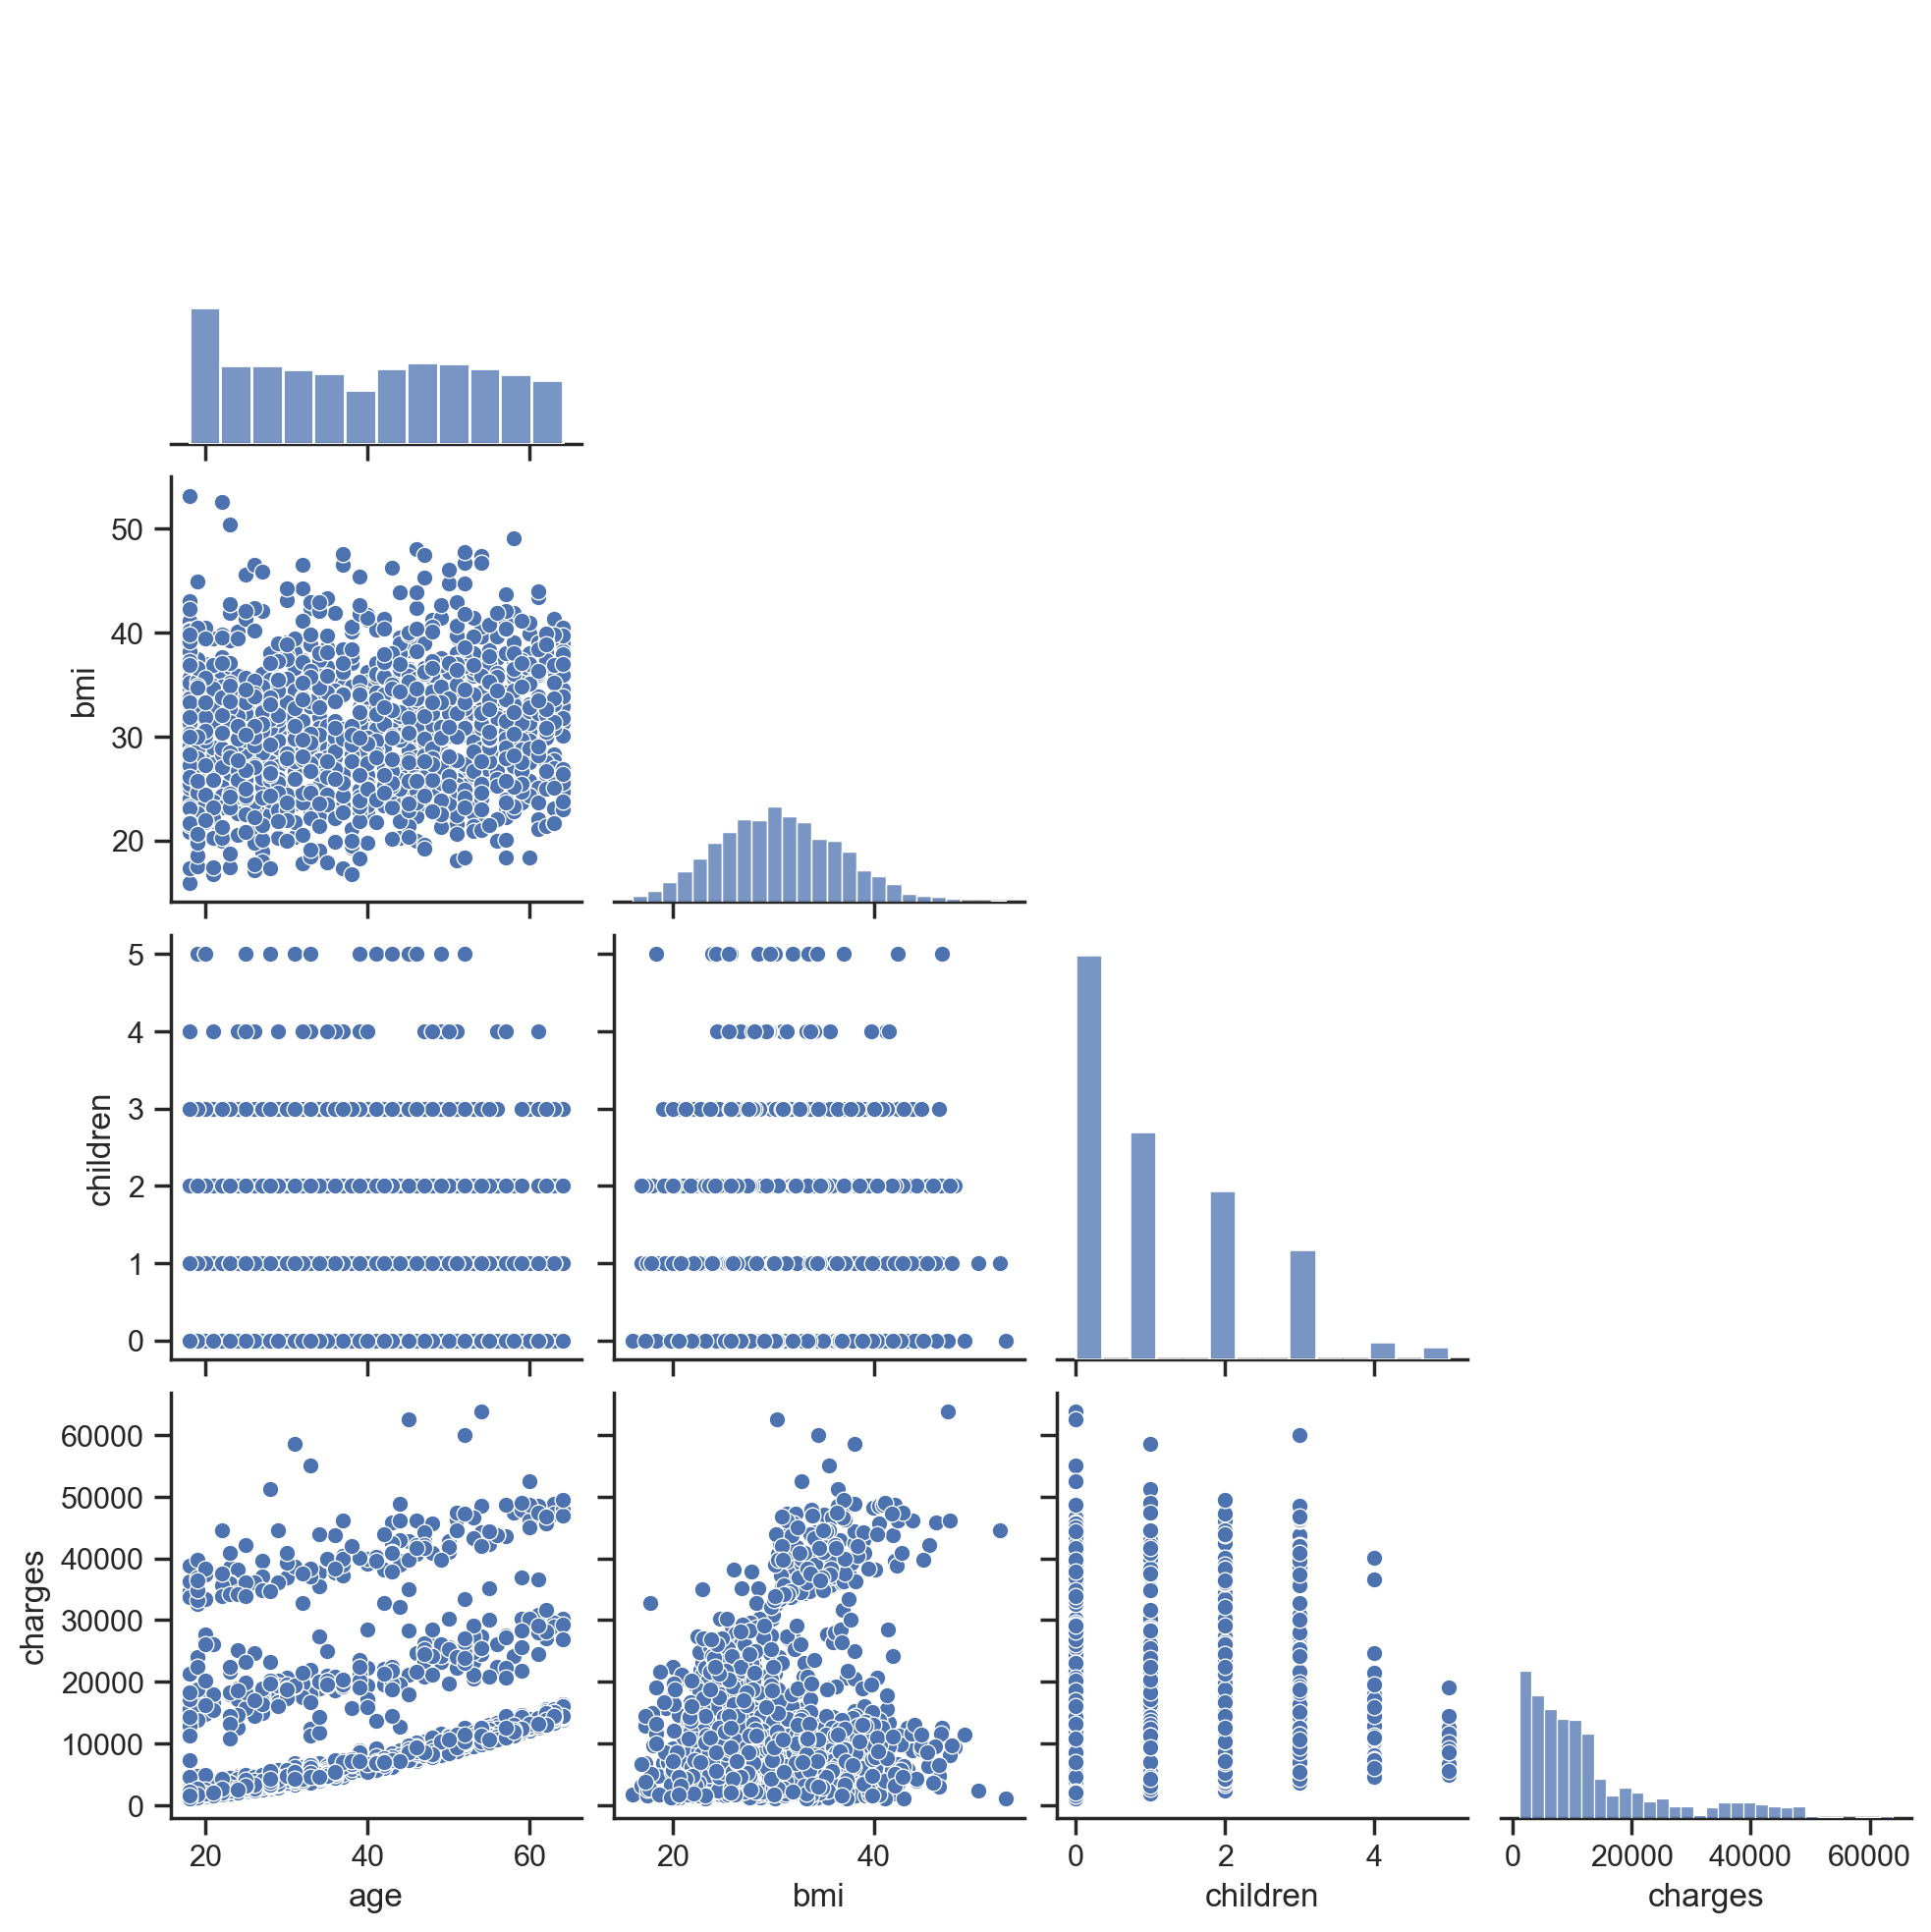

In [5]:
sns.pairplot(data=df, corner=True)
plt.show()

What we can learn from the chart:
- The group of young people at their early 20s is larger than the other age groups.
- `bmi` is almost normal distributed, while `charges` is right-skewed as we've learned from its statistics.
- higher `charges` seems from indivuals with larger `bmi`.
- `charges` seem to be positively associated with `age`, but subdivided into 3 curves.

The relationship between charges and age is interesting, and observers seem to fall into three groups. I can think of two potential reasons:
- Family income
- Health status

The dataset doesn't contain any information about family income, but `bmi` is closely related to health status.
According to [CDC](https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html#InterpretedAdults), BMI can be interpreated to 4 groups: Underweight (below 18.5), Healthy Weight (18.5-24.9), Overweight (25.0-29.9), Obesity (30.0 and Above).

### Charges vs. BMI Level

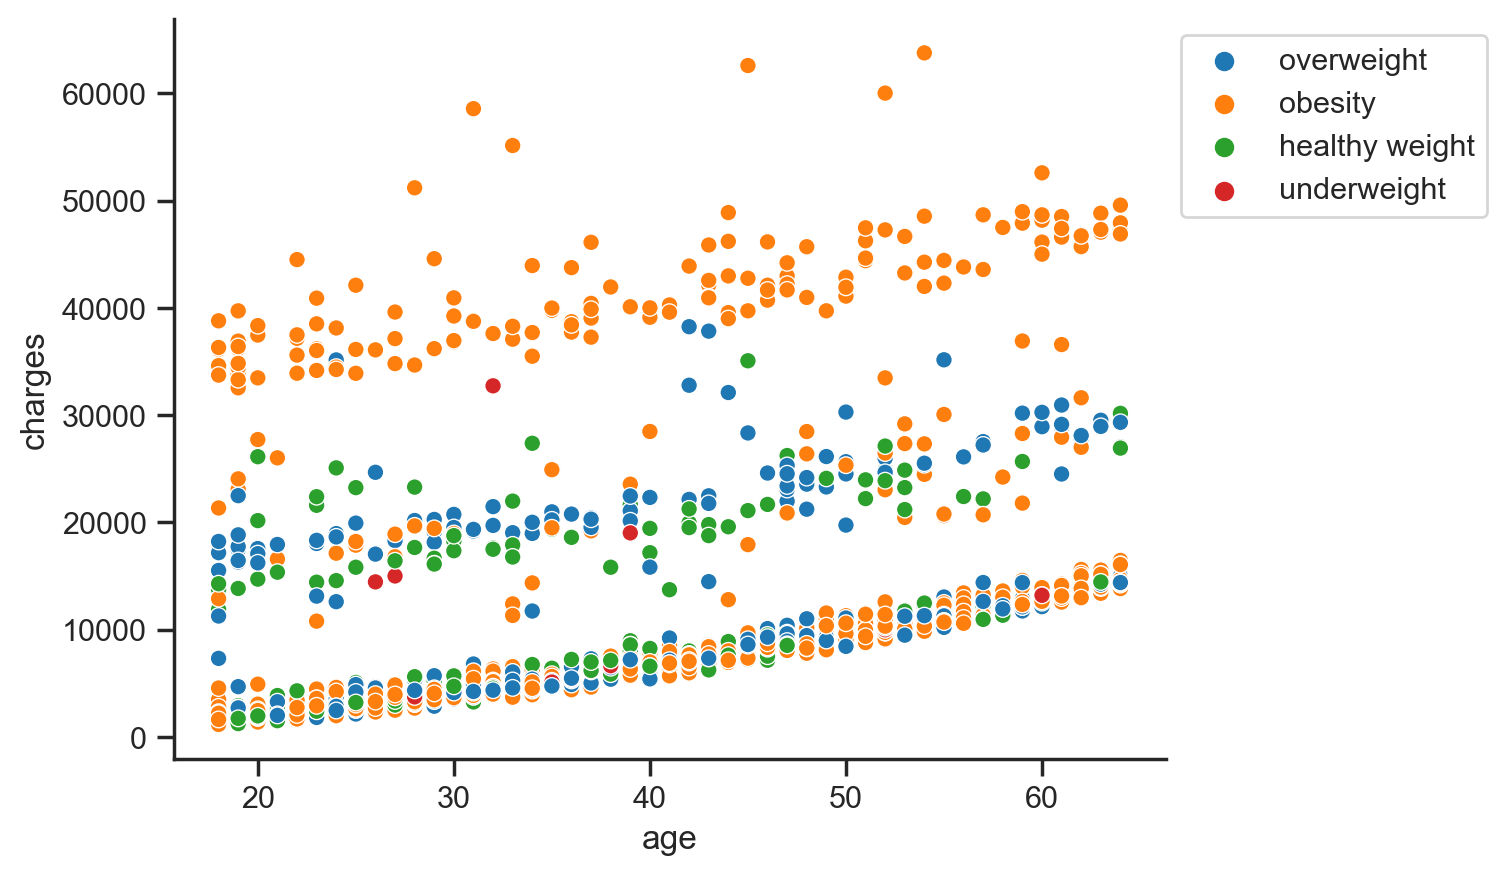

In [6]:
df['bmi_level']='underweight'
df.loc[df['bmi']>18.5, 'bmi_level'] = 'healthy weight'
df.loc[df['bmi']>25, 'bmi_level'] = 'overweight'
df.loc[df['bmi']>30, 'bmi_level'] = 'obesity'

ax = sns.scatterplot(data=df, x="age", y="charges", hue="bmi_level", palette="tab10")
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

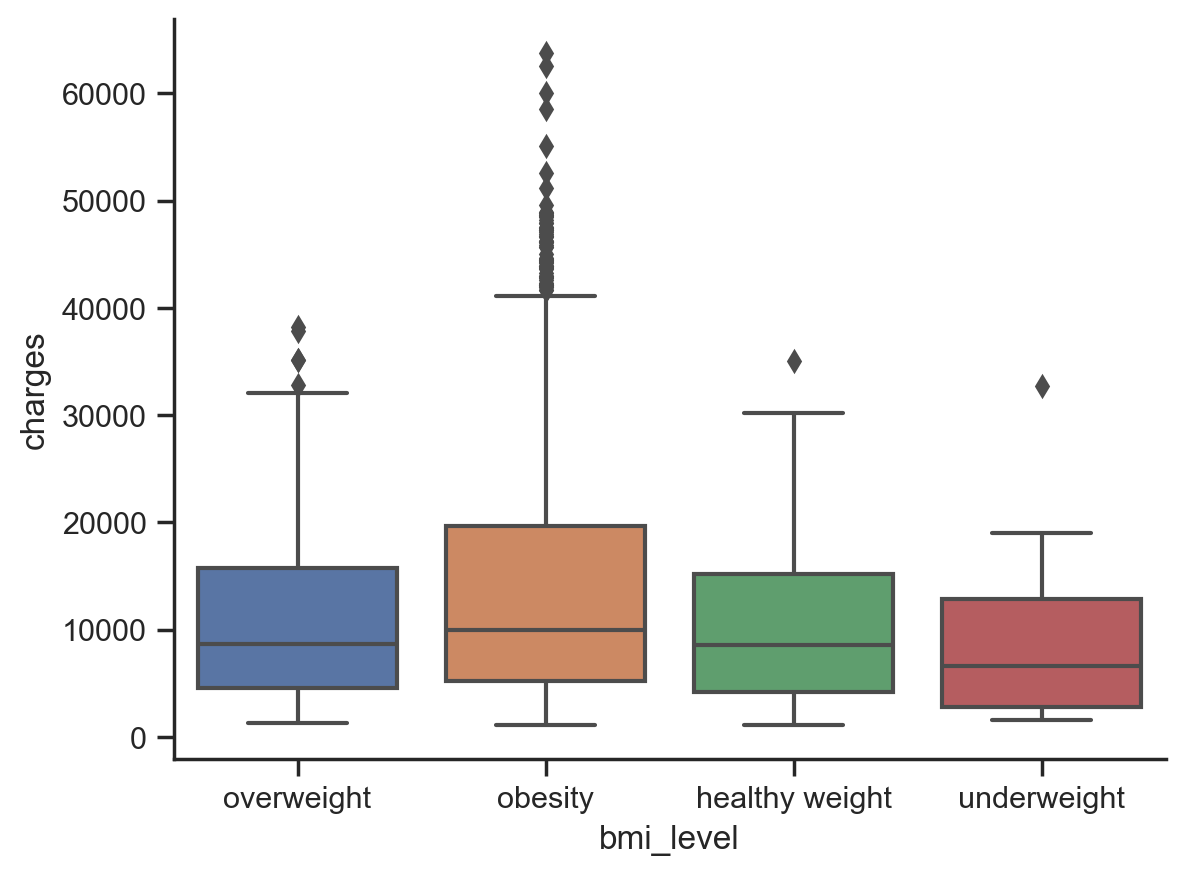

In [7]:
# boxplot chart of different BMI level
sns.boxplot(data=df, x="bmi_level", y="charges")
plt.show()

Charges increase as age increases, but overall, the group with highest charges (higher than 30,000) are strongly associated with **obesity**.

### Charges vs. Sex

**Class Balance for Sex**

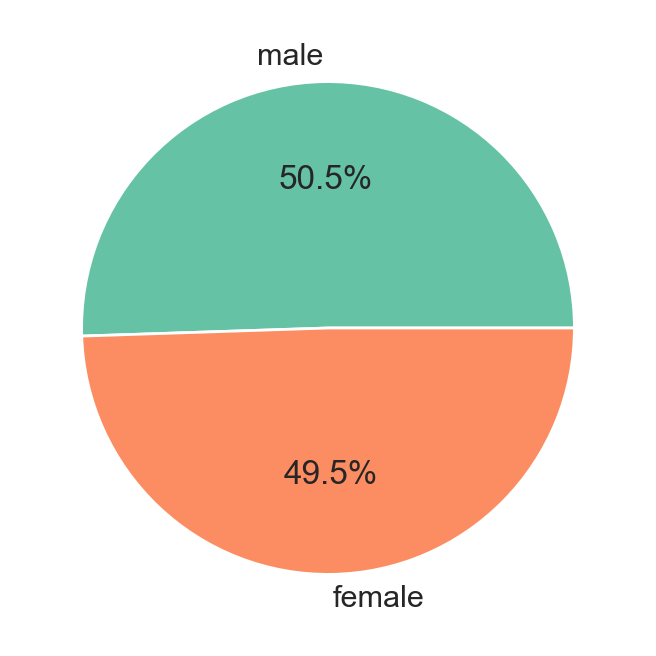

In [8]:
def plot_pie(data, col):
    counts = data[col].value_counts().reset_index()
    colors = sns.color_palette("Set2")
    plt.figure(figsize=(4, 4))
    plt.pie(counts[col].tolist(), labels=counts['index'].tolist(), colors=colors, autopct='%.1f%%')
    plt.show()

plot_pie(df, 'sex')

The dataset in balanced in sex.

**Boxplots for Sex**

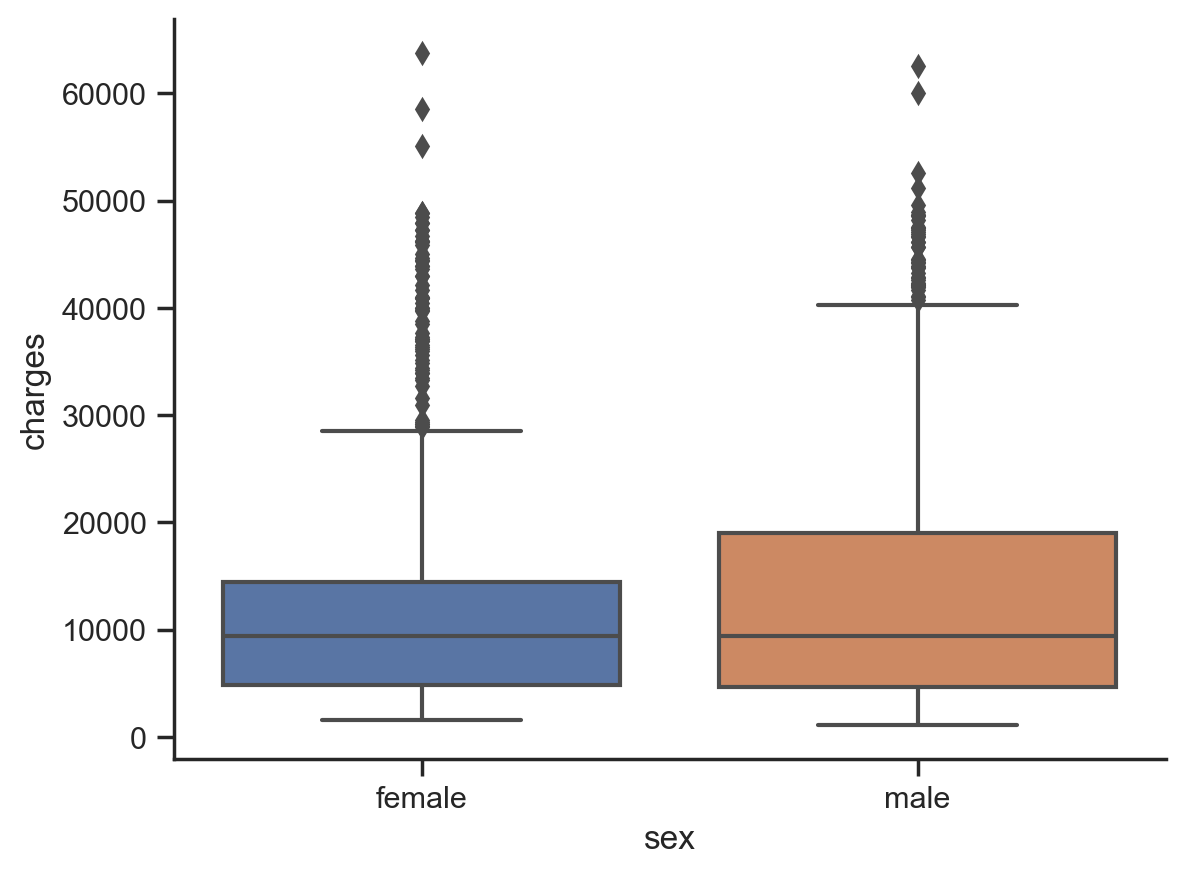

In [9]:
# boxplot chart of different sex
sns.boxplot(data=df, x="sex", y="charges")
plt.show()

Male is associated with higher charges.

### Charges vs. Smoker

**Class Balance for Smoker**

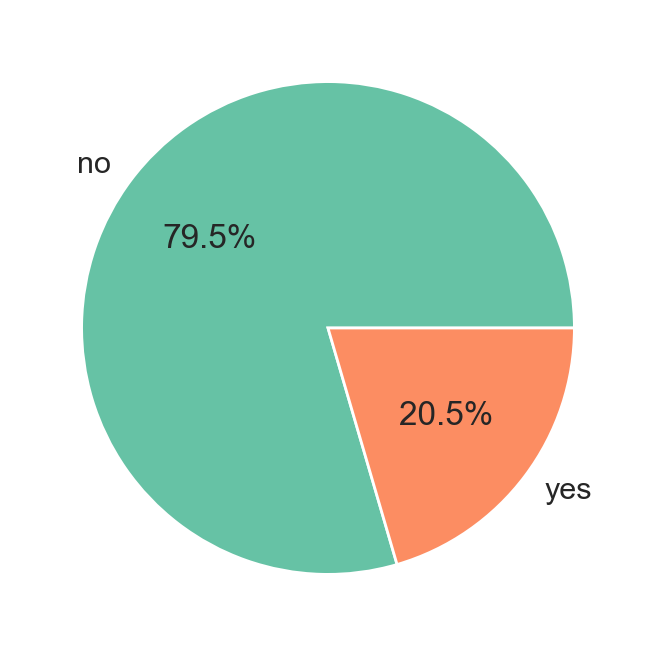

In [10]:
plot_pie(df, 'smoker')

Number of smokers and non smokers are not equal, but that's probably how real life data look like.
Let's leave it as it is.

**Boxplots for Smoker**

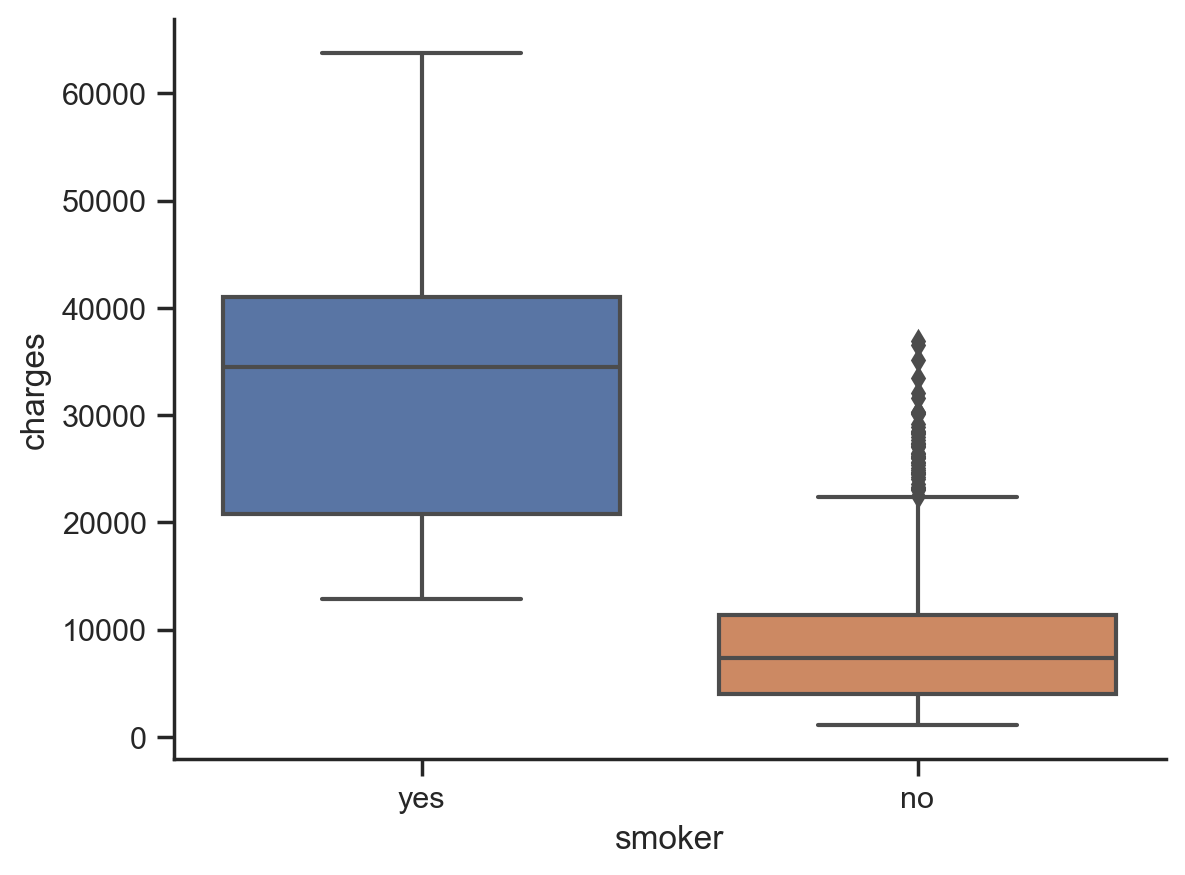

In [11]:
sns.boxplot(data=df, x="smoker", y="charges")
plt.show()

Smokers are associated with higher charges.

### Charges vs. Region

**Class Balance for Region**

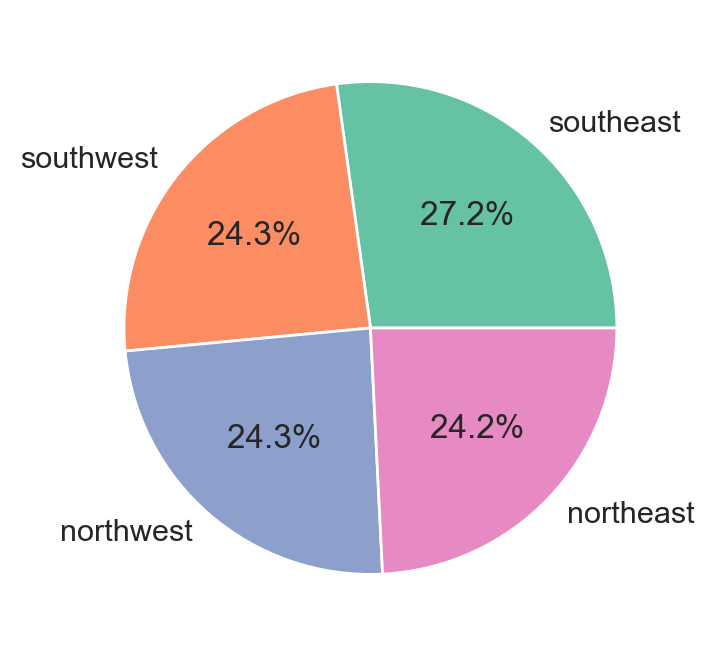

In [12]:
plot_pie(df, 'region')

Southest has a little more records than other regions, but it can basically be considered balanced.

**Boxplots for Region**

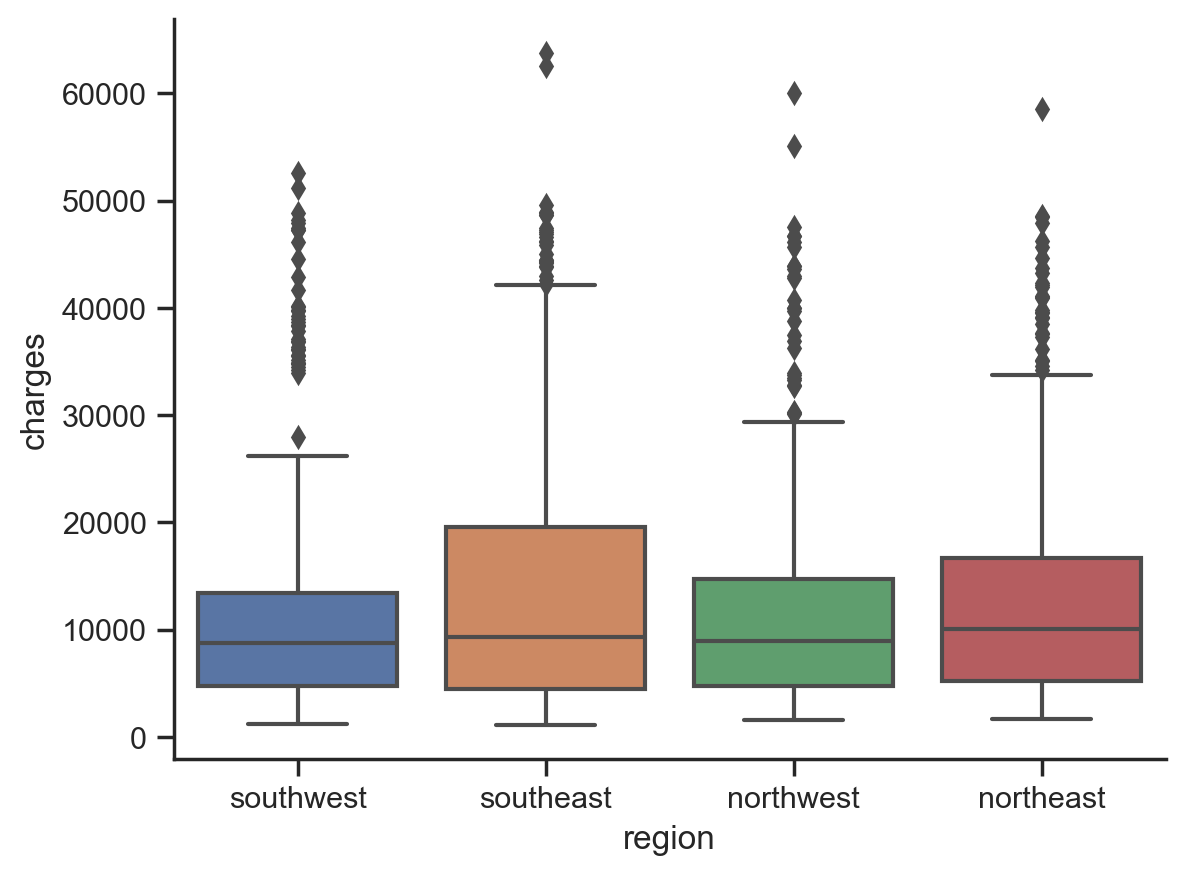

In [13]:
sns.boxplot(data=df, x="region", y="charges")
plt.show()

Southest is associated with higher charges.

## 4. Feature Engineering

We've known that different Sex, Smoker, and Region impact charges differently. In this section, we will go a step further.

First, we need to convert categorical variables into numerical values.

### One-Hot Encoding

In [14]:
# no need to keep bmi_level as it contains less information than bmi
df = df.drop(columns=['bmi_level'])
df_dummies = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], prefix='', prefix_sep='')
df_dummies.head()

,age,bmi,children,charges,female,male,no,yes,northeast,northwest,southeast,southwest
0,19,27.900,0,16884.924,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.552,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.462,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.471,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.855,0,1,1,0,0,1,0,0


Next, we can remove 3 redundant variables to reduce the impact of multicollinearity.

In [15]:
df_dummies.drop(columns=['male', 'no', 'northeast'], inplace=True)
df_dummies.rename(columns={'yes': 'smoker'}, inplace=True)
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1338 non-null   int64  
 1   bmi        1338 non-null   float64
 2   children   1338 non-null   int64  
 3   charges    1338 non-null   float64
 4   female     1338 non-null   uint8  
 5   smoker     1338 non-null   uint8  
 6   northwest  1338 non-null   uint8  
 7   southeast  1338 non-null   uint8  
 8   southwest  1338 non-null   uint8  
dtypes: float64(2), int64(2), uint8(5)
memory usage: 48.5 KB


## 5. Correlation Matrix

Now all variables are numeric, we can convieniently visualize their correlations with heatmap.

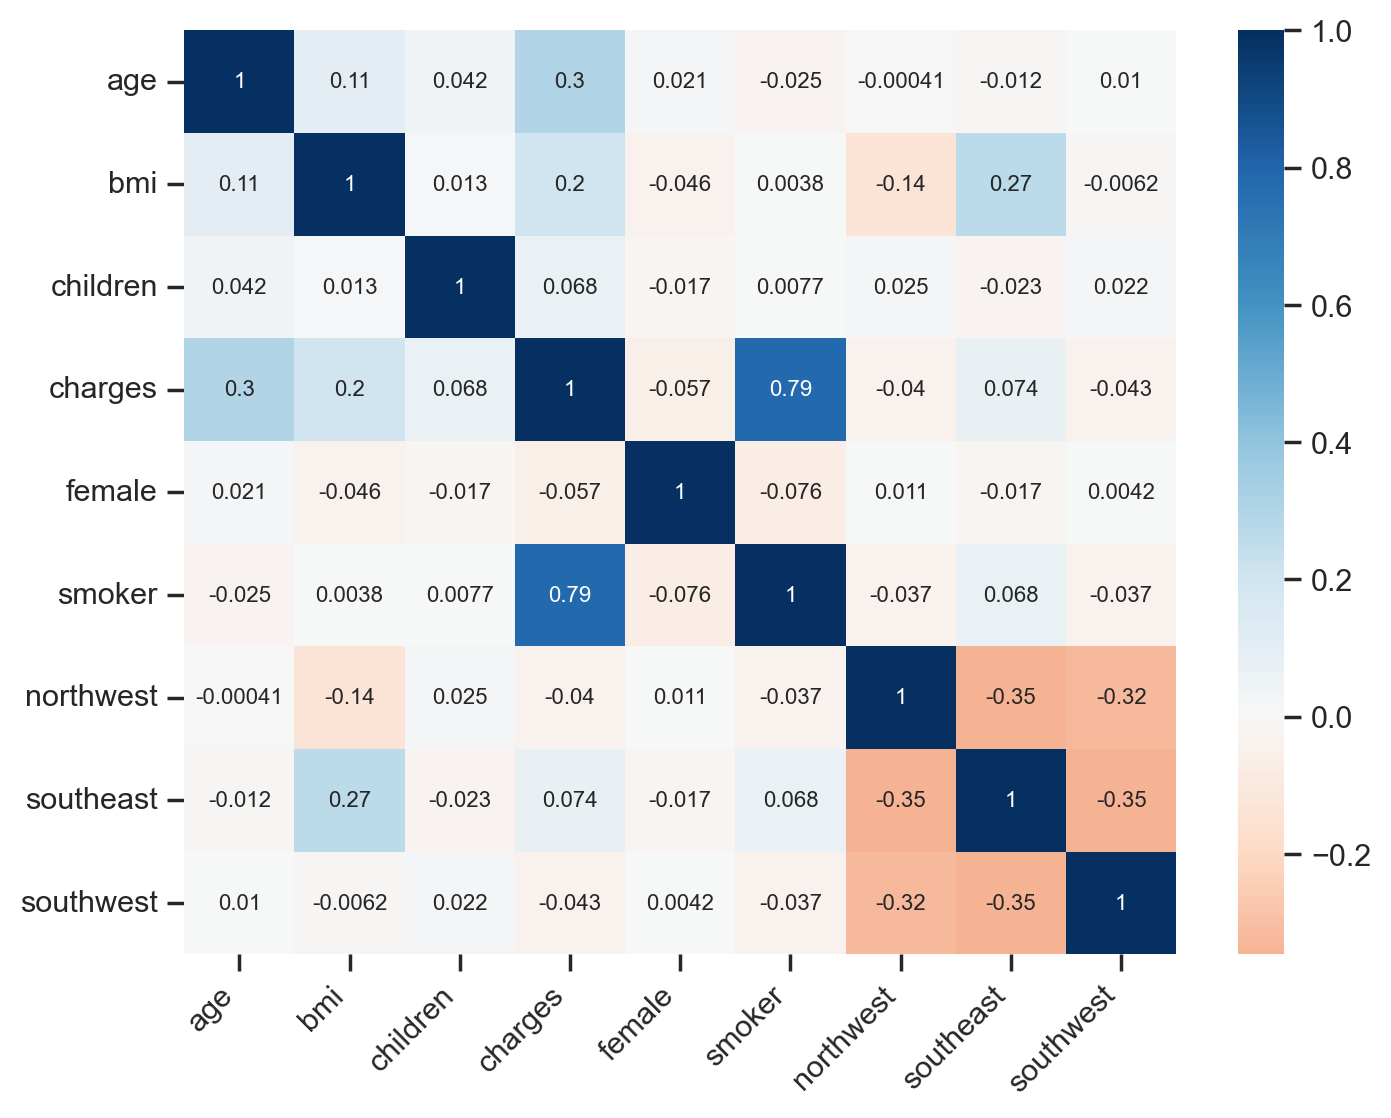

In [16]:
plt.figure(figsize=(8, 6))
chart = sns.heatmap(data=df_dummies.corr(), annot=True, annot_kws={"fontsize":8}, center=0, cmap="RdBu")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

We found 2 variables that may have correlations with charges. `charges` is strongly positively correlated with `smokers`, and weakly positively correlated with `age`.

## 6. Prepare Training and Testing Dataset

### Standardize Data

Many machine learning algorithms work better when the data is or approximately normally distributed. However, we've known this dataset contains many not normal variables, such as `age` and `children`. To fix that, we can use **StandardScaler** to tranform the data.

To avoid data leakage, we will need to split training and testing dataset first, and then apply the mean and standard deviation of training dataset to testing dataset.

In [17]:
def train_test_standardscaler(data, target, test_size, random_state):
    # split X and y
    X = data.copy()
    y = X.pop(target)
    y = y.values.reshape(-1, 1)

    # split train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # get mean and standard deviation
    X_train_mean = X_train.mean()
    X_train_std = X_train.std(ddof=0)
    y_train_mean = y_train.mean()
    y_train_std = y_train.std(ddof=0)

    # standardize train dataset
    X_train_ss = (X_train - X_train_mean)/X_train_std
    y_train_ss = (y_train - y_train_mean)/y_train_std
    
    # standardize test dataset
    X_test_ss = (X_test - X_train_mean)/X_train_std
    y_test_ss = (y_test - y_train_mean)/y_train_std    

    return (X_train, X_test, y_train, y_test, 
            X_train_ss, X_test_ss, y_train_ss, y_test_ss,
            X_train_mean, X_train_std, y_train_mean, y_train_std)

(X_train, X_test, y_train, y_test, 
 X_train_ss, X_test_ss, y_train_ss, y_test_ss,
 X_train_mean, X_train_std, y_train_mean, y_train_std) = train_test_standardscaler(df_dummies, 
                                                                               target='charges', 
                                                                               test_size=0.2, 
                                                                               random_state=123)

In [18]:
X_train_ss.head()

,age,bmi,children,female,smoker,northwest,southeast,southwest
67,0.062,-0.720,-0.067,-0.989,-0.500,1.721,-0.621,-0.548
736,-0.151,1.287,-0.886,1.011,2.000,-0.581,1.610,-0.548
310,0.771,-0.672,-0.886,-0.989,-0.500,-0.581,-0.621,1.825
963,0.487,-0.972,1.571,-0.989,-0.500,-0.581,-0.621,-0.548
680,-1.285,-2.201,-0.067,1.011,-0.500,-0.581,-0.621,1.825


In [19]:
y_train_ss

array([[-0.56485764],
       [ 2.26194272],
       [-0.39414333],
       ...,
       [-0.90193897],
       [-0.95400804],
       [ 2.78049312]])

In [20]:
# double check the corresponding dimensions
print(f'the shape of X_train is: {X_train_ss.shape}')
print(f'the shape of X_test is: {X_test_ss.shape}')
print(f'the shape of y_train is: {y_train_ss.shape}')
print(f'the shape of y_test is: {y_test_ss.shape}')

the shape of X_train is: (1070, 8)
the shape of X_test is: (268, 8)
the shape of y_train is: (1070, 1)
the shape of y_test is: (268, 1)


Now training data and testing data account for 80% and 20% of the whole group respectively, and both have been standardized.

Next, let's start to train models.

## 7. Linear Regression

### Training and Prediction

In [21]:
# train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_ss, y_train_ss)

LinearRegression()

Then we can predict the target variable for test dataset. Don't forget to convert it back to original format.

In [22]:
# y_test_predict_ss is the output after standardization
y_test_ss_pred = lr_model.predict(X_test_ss)

# convert it back to original format
y_test_pred = y_test_ss_pred * y_train_std + y_train_mean

### Predicted Values Visualization 

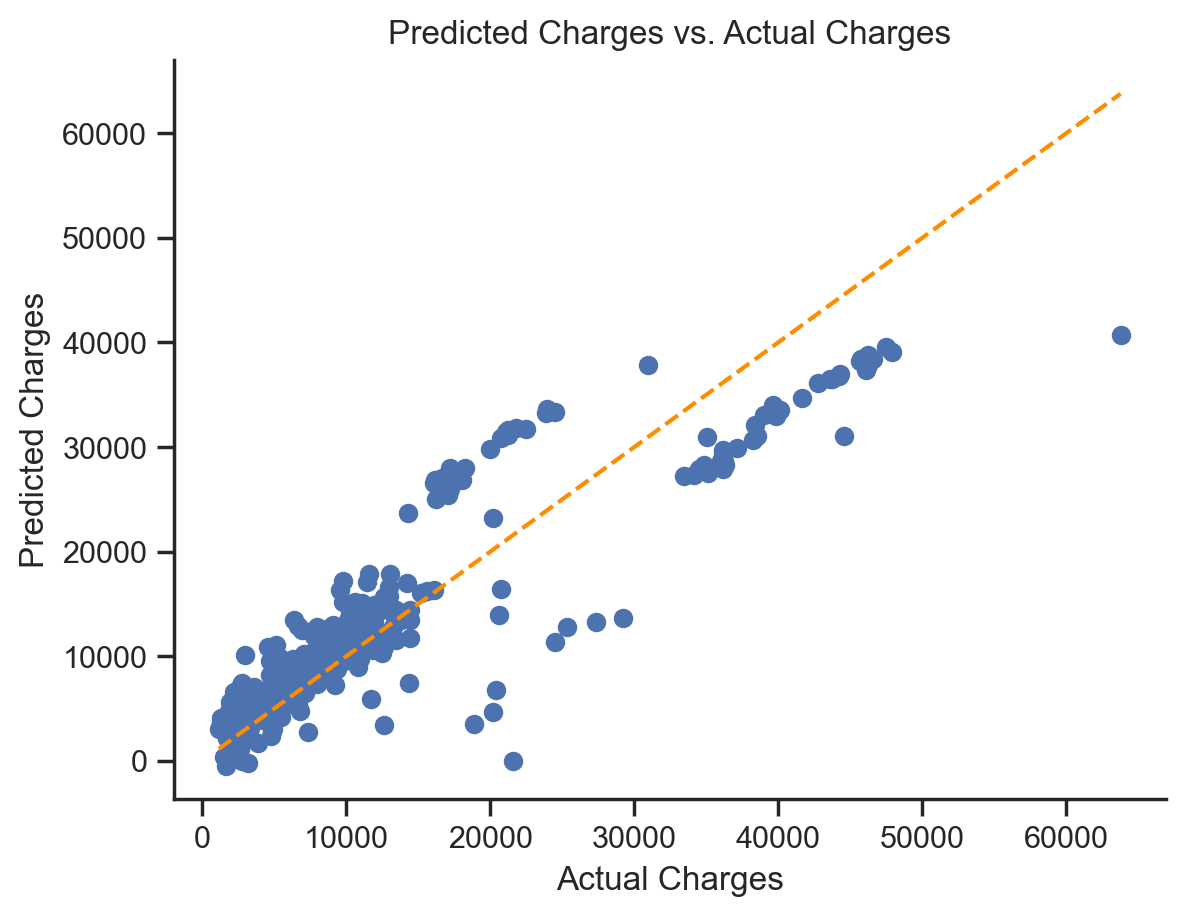

In [23]:
# Visualizing the differences between actual charges and predicted values
def visualize_prediction(y_test, y_test_pred):
    plt.scatter(y_test, y_test_pred)
    # Plotting the diagonal line
    line_coords = np.arange(y_test.min(), y_test.max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.xlabel("Actual Charges")
    plt.ylabel("Predicted Charges")
    plt.title("Predicted Charges vs. Actual Charges")
    plt.show()
    
visualize_prediction(y_test, y_test_pred)

### Model Evaluation

**Metrics for evaludation:**

**𝑅^2** : It is a measure of the linear relationship between X and Y. It is interpreted as the proportion of the variance in the dependent variable that is predictable from the independent variable.

**Adjusted 𝑅^2** :The adjusted R-squared compares the explanatory power of regression models that contain different numbers of predictors.

**MAE** : It is the mean of the absolute value of the errors. It measures the difference between two continuous variables, here actual and predicted values of y. 

**MSE**: The mean square error (MSE) is just like the MAE, but squares the difference before summing them all instead of using the absolute value. 

**RMSE**: The mean square error (MSE) is just like the MAE, but squares the difference before summing them all instead of using the absolute value. 

In [24]:
def model_evaludation(X_test, y_test, y_test_pred, model_name):
    r2 = metrics.r2_score(y_test, y_test_pred)

    # Ajusted R^2
    # p represents the number of independent variables
    # n represents the number of data points
    p = X_test.shape[1]
    n = X_test.shape[0]
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    mae = metrics.mean_absolute_error(y_test, y_test_pred)
    mse = metrics.mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)
   
    # save to a dataframe
    df_performance = pd.DataFrame({'Metric':['R^2', 'Adjusted R^2', 'MAE', 'MSE', 'RMSE'],
                                   model_name: [r2, adjusted_r2, mae, mse, rmse]})
    df_performance = df_performance.set_index('Metric')
    return df_performance
    
lr_model_performance = model_evaludation(X_test, y_test, y_test_pred, model_name='Linear Regression')
lr_model_performance

,Linear Regression
Metric,
R^2,0.800
Adjusted R^2,0.794
MAE,4013.101
MSE,30552437.417
RMSE,5527.426


## 8. Polynomial Regression

### Training and Prediction

In [25]:
poly = PolynomialFeatures(degree = 3)
# transform X_train to be [X, X^2, X^3]
X_train_ss_poly = poly.fit_transform(X_train_ss)
lr_poly_model = LinearRegression()
# train the linear model with poly features
lr_poly_model.fit(X_train_ss_poly, y_train_ss)

LinearRegression()

Next, predict the target variable for test dataset and convert it back to original format.

In [26]:
# get poly features of X_test
X_test_ss_poly = poly.fit_transform(X_test_ss)

# y_test_predict_ss is the output after standardization
y_test_ss_pred_poly = lr_poly_model.predict(X_test_ss_poly)

# convert it back to original format
y_test_pred_poly = y_test_ss_pred_poly * y_train_std + y_train_mean

### Predicted Values Visualization 

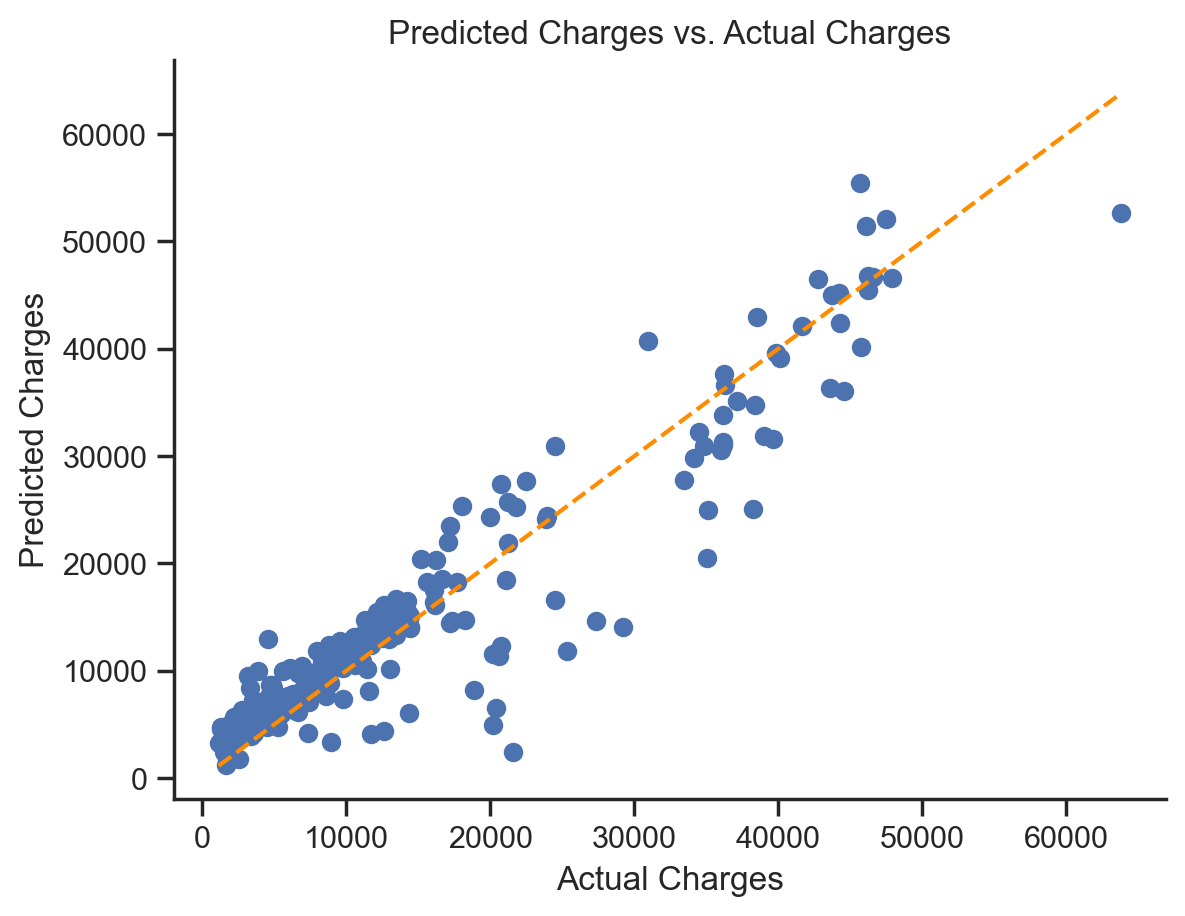

In [27]:
visualize_prediction(y_test, y_test_pred_poly)

### Model Evaludation

In [28]:
poly_model_performance = model_evaludation(X_test, y_test, y_test_pred_poly, model_name='Polynomial Regression')
poly_model_performance

,Polynomial Regression
Metric,
R^2,0.888
Adjusted R^2,0.885
MAE,2798.219
MSE,17129711.672
RMSE,4138.806


It has better performance than Linear Regression Model, 𝑅^2 has been increased from 0.8 to 0.887.

## 9. Neural Network

### Train the model

In [43]:
tf.random.set_seed(123) # for consistent results
nn_model = Sequential(
    [      
        # the input, layer 0
        tf.keras.Input(shape=(8,)),
        # layers
        Dense(units=15, name="l1", activation="relu"),
        Dense(units=10, name="l2", activation="relu"),
        Dense(units=1, name="l3", activation="linear")
    ], name = "nn_model" 
)
nn_model.summary()

Model: "nn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l1 (Dense)                  (None, 15)                135       
                                                                 
 l2 (Dense)                  (None, 10)                160       
                                                                 
 l3 (Dense)                  (None, 1)                 11        
                                                                 
Total params: 306
Trainable params: 306
Non-trainable params: 0
_________________________________________________________________


In [44]:
nn_model.compile(
    loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
)

history = nn_model.fit(X_train_ss, y_train_ss, epochs=80, batch_size=20, validation_split=0.2)

Epoch 1/80
43/43 [==============================] - 1s 5ms/step - loss: 1.3916 - val_loss: 1.4440
Epoch 2/80
43/43 [==============================] - 0s 2ms/step - loss: 1.1802 - val_loss: 1.2495
Epoch 3/80
43/43 [==============================] - 0s 2ms/step - loss: 1.0310 - val_loss: 1.0971
Epoch 4/80
43/43 [==============================] - 0s 2ms/step - loss: 0.9095 - val_loss: 0.9625
Epoch 5/80
43/43 [==============================] - 0s 2ms/step - loss: 0.7970 - val_loss: 0.8324
Epoch 6/80
43/43 [==============================] - 0s 2ms/step - loss: 0.6850 - val_loss: 0.7060
Epoch 7/80
43/43 [==============================] - 0s 2ms/step - loss: 0.5788 - val_loss: 0.5909
Epoch 8/80
43/43 [==============================] - 0s 2ms/step - loss: 0.4845 - val_loss: 0.4859
Epoch 9/80
43/43 [==============================] - 0s 2ms/step - loss: 0.4066 - val_loss: 0.4068
Epoch 10/80
43/43 [==============================] - 0s 2ms/step - loss: 0.3504 - val_loss: 0.3516
Epoch 11/80
43/43 [

In [45]:
# make a prediction
y_test_ss_pred_nn = nn_model.predict(X_test_ss)

# convert it back to original format
y_test_pred_nn = y_test_ss_pred_nn * y_train_std + y_train_mean

9/9 [==============================] - 0s 1ms/step


### Predicted Values Visualization

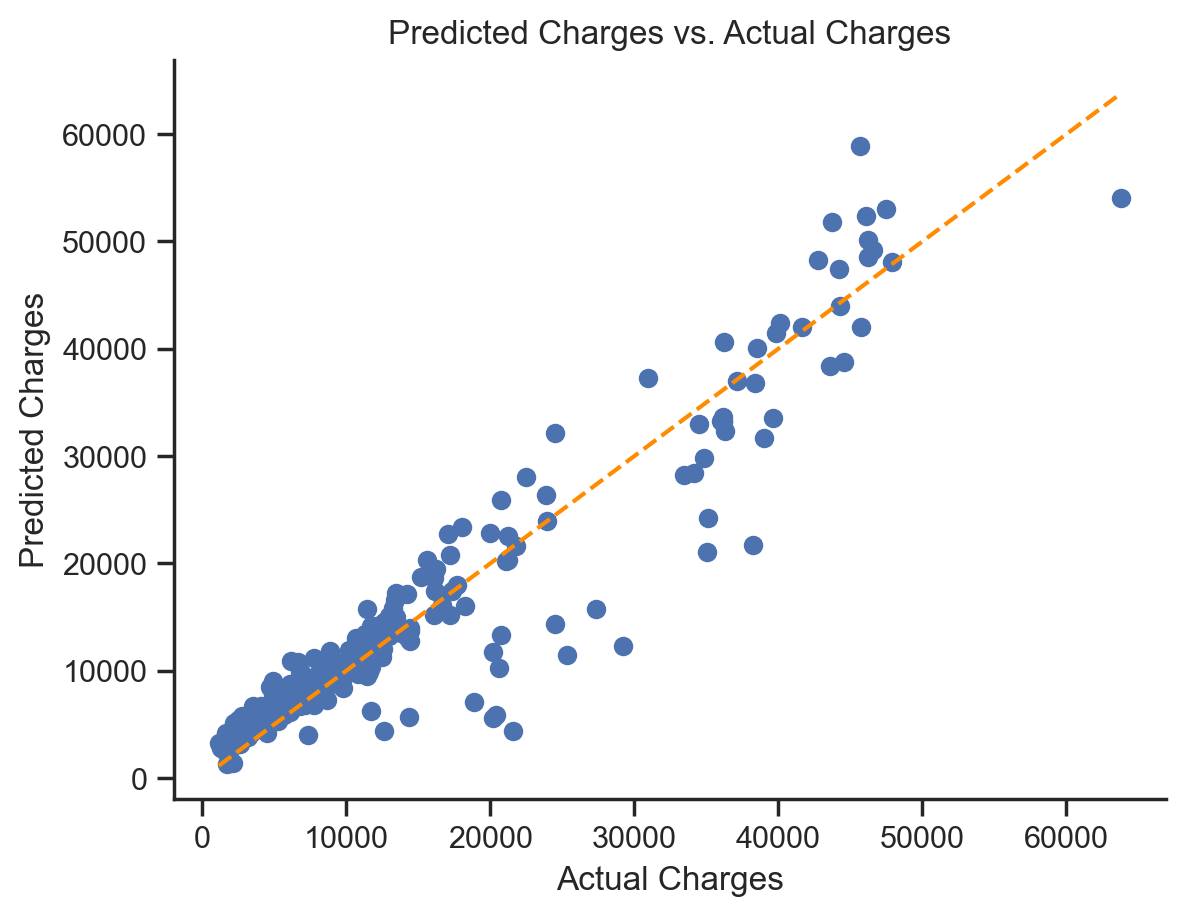

In [46]:
visualize_prediction(y_test, y_test_pred_nn)

### Loss Visualisation

In [47]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

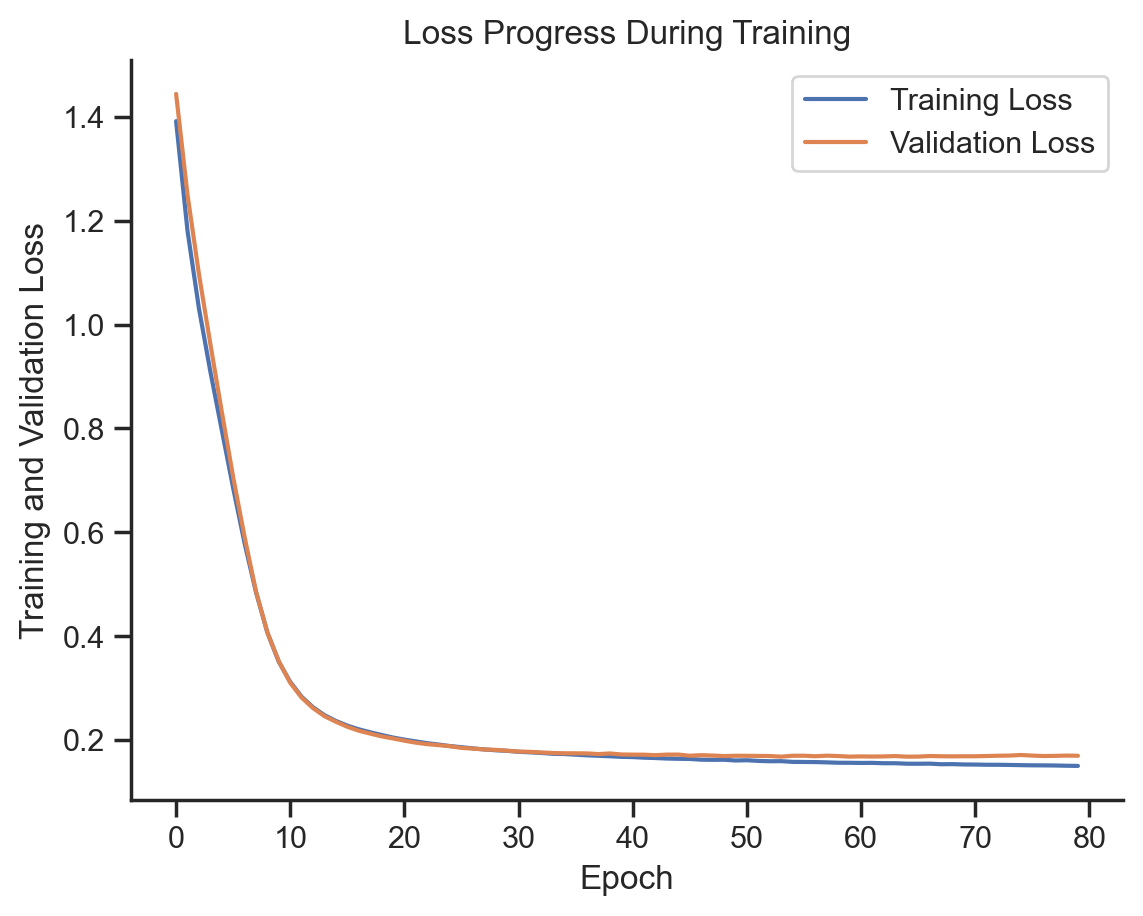

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

The curve of training loss and validation loss are very close, which means the model is neither overfitting
nor underfitting.

### Model Evaluation

In [49]:
nn_model_performance = model_evaludation(X_test, y_test, y_test_pred_nn, model_name='Neural Networks')
nn_model_performance

,Neural Networks
Metric,
R^2,0.896
Adjusted R^2,0.893
MAE,2536.828
MSE,15911061.017
RMSE,3988.867


## 10. Conclusion

Let's compare the performance of the 3 models:

In [50]:
lr_model_performance.join(poly_model_performance).join(nn_model_performance)

,Linear Regression,Polynomial Regression,Neural Networks
Metric,,,
R^2,0.800,0.888,0.896
Adjusted R^2,0.794,0.885,0.893
MAE,4013.101,2798.219,2536.828
MSE,30552437.417,17129711.672,15911061.017
RMSE,5527.426,4138.806,3988.867


In this project, **Neural Networks** is the optimal model as it has the highest adjusted R^2 0.893 and smallest Mean Squared Error (MSE).